Data Engineering

In [103]:
!pip install imblearn

     ---------------------------------------- 0.0/238.4 kB ? eta -:--:--
     --- ------------------------------------ 20.5/238.4 kB ? eta -:--:--
     ---------------- --------------------- 102.4/238.4 kB 1.5 MB/s eta 0:00:01
     -------------------------------------- 238.4/238.4 kB 2.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: C:\Users\andin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [104]:
# Extract Data from csv
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np

model_names = ["Logistic_Regression", "Decision_Tree", "Random_Forest", "XGBoost", 
            "SVC", "KNN", "Naive_Bayes", "Neural_Network", "Gradient_Boosting", "Voting_Classifier", "KMeans"]
metrics = ["accuracy", "precision", "recall", "f1_score"]

models_name = []

metrics_train = {}
metrics_test = {}

# metrics
for model in model_names:
    for metric in metrics:
        metrics_train[f"{metric}_{model}"] = []
        metrics_test[f"{metric}_{model}"] = []

models = []

# Load dataset
data = pd.read_csv("test/over_features.csv")

# take only first 10000 rows (due to speed issues)
data = data.iloc[:10000]

# Check for missing values
print("Missing values in data:")
print(data.isnull().sum())

# Remove rows with missing values
data.dropna(inplace=True)

# remove identifier
data = data.drop(columns=["match_id"])

# Feature Engineering: Add enhanced features (from data engineering)
data["pressure_index"] = data["dot_ball_pressure"] * data["required_desired_run_rate"]
data["wicket_pressure"] = data["number_of_wickets_lost"] * data["required_desired_run_rate"]
data["late_over_flag"] = (data["over"] > 15).astype(int)
data["bowler_pressure"] = data["current_bowler_economy"] * (data["bowler_wickets_in_match"] + 1)
data["aggressiveness_index"] = data["striker_strike_rate"] * (data["striker_boundaries_hit"] + 1)

print(len(data))
print(data.columns)

# Encode 'team' column with numbers
team_mapping = {team: idx for idx, team in enumerate(data["team"].unique())}
data["team_encoded"] = data["team"].map(team_mapping)

# Encode 'match_phase' column with numbers
phase_mapping = {phase: idx for idx, phase in enumerate(data["match_phase"].unique())}
data["match_phase_encoded"] = data["match_phase"].map(phase_mapping)

# Drop original categorical columns
data_encoded = data.drop(columns=["team", "match_phase"])

# Drop "striker_boundaries_hit" due to feature engineering 
data_encoded = data_encoded.drop(columns=["striker_boundaries_hit"])

# Also drop "total_completed_overs" from another feature engineering section
data_encoded = data_encoded.drop(columns=["total_overs_completed"])

# Train-test split
train_data, test_data = train_test_split(data_encoded, test_size=0.2, random_state=42)

# Split x and y
X_train = train_data.drop(columns=["wicket_next_over"])
y_train = train_data["wicket_next_over"]

X_test = test_data.drop(columns=["wicket_next_over"])
y_test = test_data["wicket_next_over"]

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# balancing
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
X_test_balanced, y_test_balanced = smote.fit_resample(X_test_scaled, y_test)

# reset X_train_scaled...
X_train_scaled = X_train_balanced
y_train = y_train_balanced
X_test_scaled = X_test_balanced
y_test = y_test_balanced

Missing values in data:
match_id                             0
innings                              0
team                                 0
over                                 0
balls_faced_by_striker               0
striker_strike_rate                  0
striker_boundaries_hit               0
dot_ball_pressure                    0
current_bowler_economy               0
bowler_wickets_in_match              0
total_overs_completed                0
overs_since_last_wicket              0
number_of_wickets_lost               0
required_desired_run_rate            0
current_run_rate                     0
wickets_lost_last_3_overs            0
number_of_boundaries_last_3_overs    0
number_of_dot_balls_last_over        0
powerplay_overs_remaining            0
match_phase                          0
wicket_next_over                     0
dtype: int64
10000
Index(['innings', 'team', 'over', 'balls_faced_by_striker',
       'striker_strike_rate', 'striker_boundaries_hit', 'dot_ball_pressure',
 

In [105]:
# Handle / plot data imbalances
# TODO


Feature Engineering

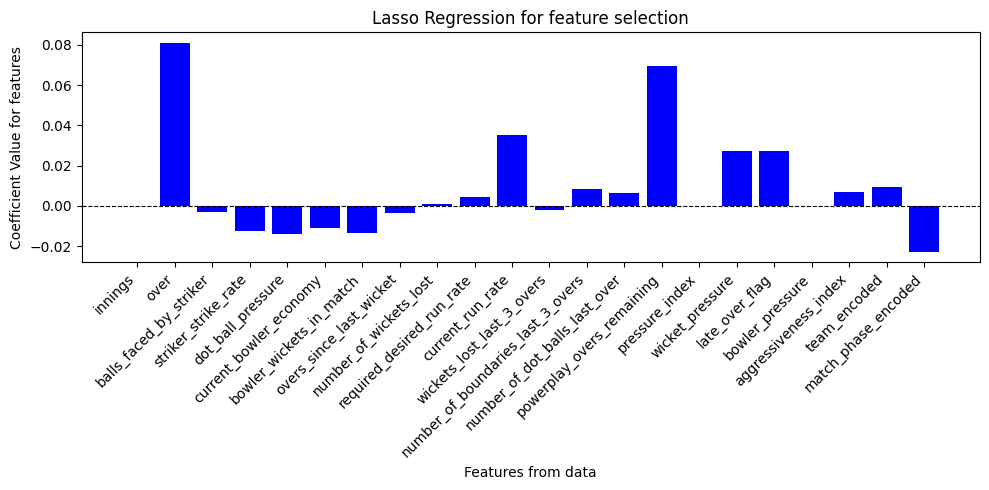

Feature Coefficients: {'innings': np.float64(8.381624992225603e-05), 'over': np.float64(0.08097197869570563), 'balls_faced_by_striker': np.float64(-0.00317088474007165), 'striker_strike_rate': np.float64(-0.012320005338242544), 'dot_ball_pressure': np.float64(-0.014045245661864403), 'current_bowler_economy': np.float64(-0.010837105548196722), 'bowler_wickets_in_match': np.float64(-0.013262528576497797), 'overs_since_last_wicket': np.float64(-0.0036299654135151737), 'number_of_wickets_lost': np.float64(0.000942874728516016), 'required_desired_run_rate': np.float64(0.004662339931673647), 'current_run_rate': np.float64(0.03531094926922716), 'wickets_lost_last_3_overs': np.float64(-0.002221243880152425), 'number_of_boundaries_last_3_overs': np.float64(0.008319145586122172), 'number_of_dot_balls_last_over': np.float64(0.006219061608195119), 'powerplay_overs_remaining': np.float64(0.06953692603730252), 'pressure_index': np.float64(0.0), 'wicket_pressure': np.float64(0.027308460468796716), 'l

In [106]:
# Regularization L1, L2, and ElasticNet
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

# Lasso Regression with Grid Search
alphas = np.logspace(-3, 1, 100) 
lasso = Lasso(max_iter=1000)
grid = GridSearchCV(lasso, param_grid={"alpha": alphas}, cv=5, scoring="r2")
grid.fit(X_train_scaled, y_train)

# Best model and feature importance
best_lasso = grid.best_estimator_
lasso_coef = best_lasso.coef_

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.bar(X_train.columns, lasso_coef, color='blue')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.xlabel("Features from data")
plt.ylabel("Coefficient Value for features")
plt.title("Lasso Regression for feature selection")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Feature Coefficients:", dict(zip(X_train.columns, lasso_coef)))


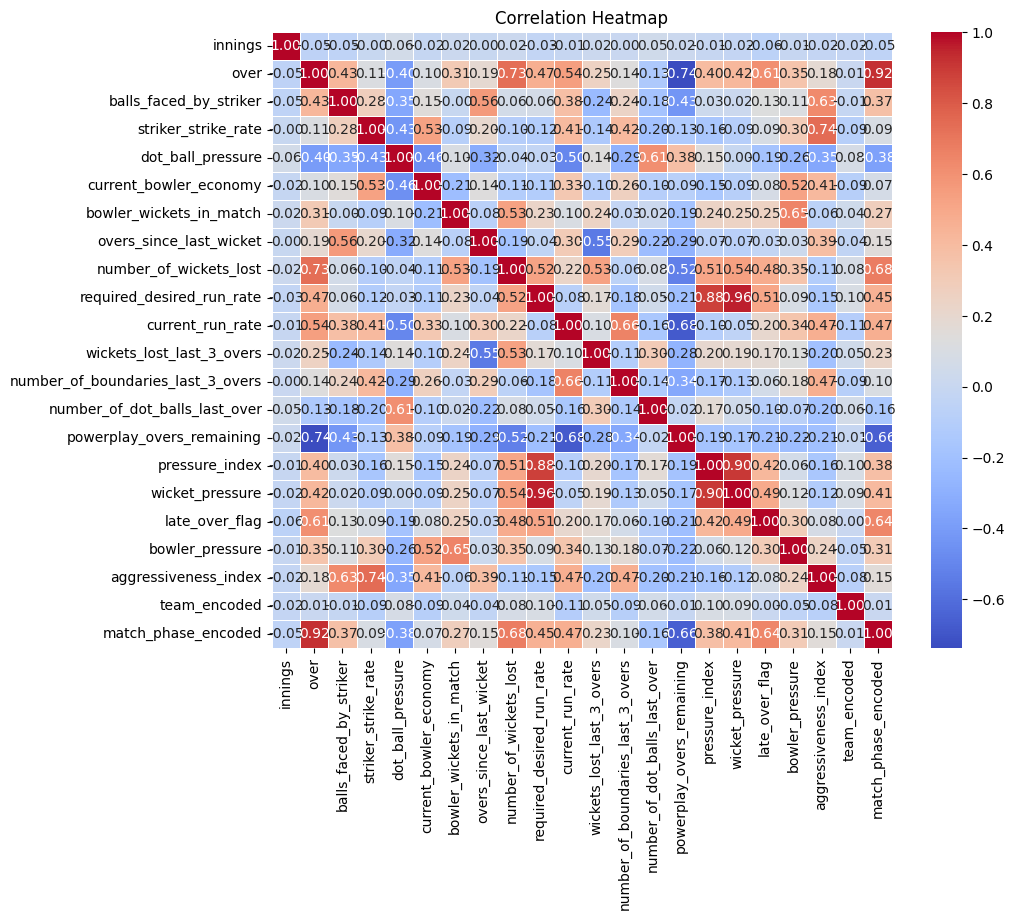

In [107]:
import seaborn as sns

# correlation matrix
correlation_matrix = X_train.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

                              Feature  Importance
20                       team_encoded    0.067815
1                                over    0.063208
5              current_bowler_economy    0.062421
18                    bowler_pressure    0.062214
19               aggressiveness_index    0.061517
3                 striker_strike_rate    0.061399
4                   dot_ball_pressure    0.060122
2              balls_faced_by_striker    0.059349
10                   current_run_rate    0.056041
9           required_desired_run_rate    0.055552
15                     pressure_index    0.055384
7             overs_since_last_wicket    0.052608
16                    wicket_pressure    0.052114
12  number_of_boundaries_last_3_overs    0.050311
13      number_of_dot_balls_last_over    0.049428
8              number_of_wickets_lost    0.047889
6             bowler_wickets_in_match    0.019680
11          wickets_lost_last_3_overs    0.019582
0                             innings    0.013563


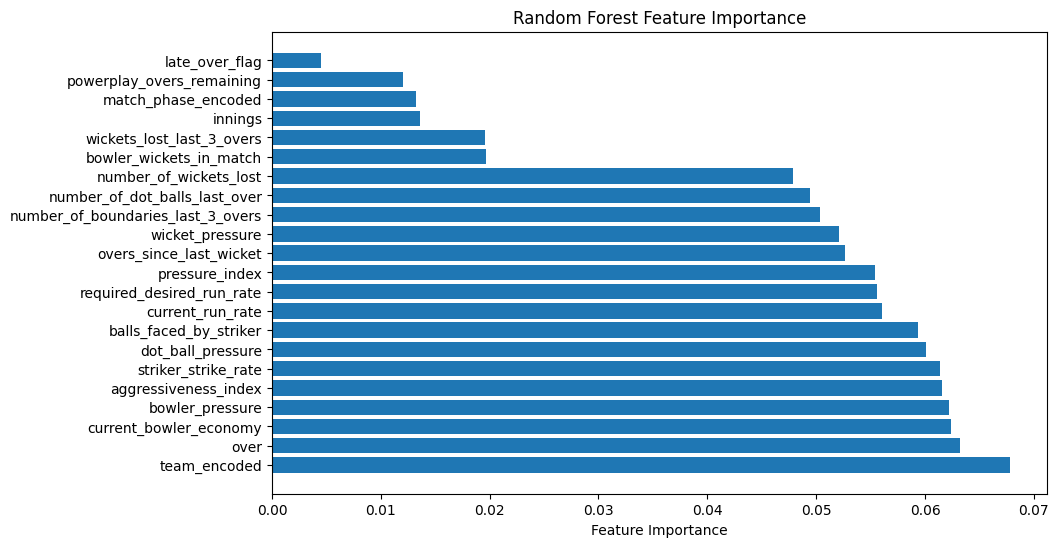

In [108]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Get feature importances
feature_importances = rf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,  
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plotting the feature importance
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

Model Training

In [109]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return accuracy, precision, recall, f1


def evaluate_model(y_train_true, y_train_pred, y_test_true, y_test_pred, model_name, model):
    # Store model
    models.append(model)
    models_name.append(model_name)

    # Calculate metrics
    accuracy_train, precision_train, recall_train, f1_train = calculate_metrics(y_train_true, y_train_pred)
    accuracy_test, precision_test, recall_test, f1_test = calculate_metrics(y_test_true, y_test_pred)

    # save metrics
    metrics_train[f"accuracy_{model_name}"] = accuracy_train
    metrics_train[f"precision_{model_name}"] = precision_train
    metrics_train[f"recall_{model_name}"] = recall_train
    metrics_train[f"f1_score_{model_name}"] = f1_train

    metrics_test[f"accuracy_{model_name}"]  = accuracy_test
    metrics_test[f"precision_{model_name}"]  = precision_test
    metrics_test[f"recall_{model_name}"]= recall_test
    metrics_test[f"f1_score_{model_name}"] = f1_test
    
    cross_validate_model(model, model_name, X_train_scaled, y_train)

def cross_validate_model(model, model_name, X, y, n_splits=5):
    average_metrics_train = {
        "accuracy": 0,
        "precision": 0,
        "recall": 0,
        "f1_score": 0
    }
    
    # Stratified K-Fold Cross-Validation
    k_folds = 0
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_index, test_index in skf.split(X, y):
        k_folds += 1
        
        # If X is a NumPy array
        X = pd.DataFrame(X)

        # If y is a 1D NumPy array
        y = pd.Series(y)
        
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_test_cv)

        # Evaluate the model
        accuracy, precision, recall, f1 = calculate_metrics(y_test_cv, y_pred_cv)
        average_metrics_train["accuracy"] += accuracy
        average_metrics_train["precision"] += precision
        average_metrics_train["recall"] += recall
        average_metrics_train["f1_score"] += f1
        
    metrics_test[f"accuracy_kfold_{model_name}"] = average_metrics_train["accuracy"] / k_folds
    metrics_test[f"precision_kfold_{model_name}"] = average_metrics_train["precision"] / k_folds
    metrics_test[f"recall_kfold_{model_name}"] = average_metrics_train["recall"] / k_folds
    metrics_test[f"f1_score_kfold_{model_name}"] = average_metrics_train["f1_score"] / k_folds

def train_and_evaluate_model(model, model_name):
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Evaluate the model
    evaluate_model(y_train, y_train_pred, y_test, y_test_pred, model_name, model)

In [110]:
# Logistic Regression model
model = LogisticRegression(multi_class='multinomial', max_iter=1000)

train_and_evaluate_model(model, "Logistic_Regression")

C:\Users\andin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\andin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\andin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2k

In [111]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree model
model = DecisionTreeClassifier(random_state=42)

train_and_evaluate_model(model, "Decision_Tree")

In [112]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest model
model = RandomForestClassifier(random_state=42)

train_and_evaluate_model(model, "Random_Forest")

In [113]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(random_state=42)

train_and_evaluate_model(model, "Gradient_Boosting")

In [114]:
# SVM
from sklearn.svm import SVC

model = SVC(random_state=42)

train_and_evaluate_model(model, "SVC")

In [115]:
# KMeans
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2, random_state=42)

train_and_evaluate_model(model, "KMeans")

In [116]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)

train_and_evaluate_model(model, "KNN")

In [117]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

train_and_evaluate_model(model, "Naive_Bayes")

In [118]:
!pip install xgboost


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: C:\Users\andin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [119]:
from xgboost import XGBClassifier

# XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

train_and_evaluate_model(model, "XGBoost")

C:\Users\andin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\training.py:183: UserWarning: [22:43:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\andin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\training.py:183: UserWarning: [22:43:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\andin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\training.py:183: UserWarning: [22:43:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } 

In [120]:
from sklearn.ensemble import VotingClassifier

# Voting Classifier
model = VotingClassifier(estimators=[
    ('logistic', LogisticRegression(multi_class='multinomial', max_iter=1000)),
    ('tree', DecisionTreeClassifier(random_state=42)),
    ('forest', RandomForestClassifier(random_state=42)),
    ('boosting', GradientBoostingClassifier(random_state=42)),
    ('xgboost', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
], voting='soft')

train_and_evaluate_model(model, "Voting_Classifier")

C:\Users\andin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\andin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\training.py:183: UserWarning: [22:43:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\andin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWar

In [121]:
!pip install torch



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: C:\Users\andin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [122]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Dynamically get the number of input features (columns in X)
num_features = X_train.shape[1]

class ImprovedWicketPredictor(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedWicketPredictor, self).__init__()
        # First hidden layer with more neurons
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)  # Second hidden layer
        self.fc3 = nn.Linear(32, 16)  # Third hidden layer
        self.fc4 = nn.Linear(16, 8)   # Fourth hidden layer
        self.fc5 = nn.Linear(8, 1)    # Output layer

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer to prevent overfitting

        # Batch Normalization
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.batch_norm3 = nn.BatchNorm1d(16)
        self.batch_norm4 = nn.BatchNorm1d(8)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.batch_norm1(x)
        x = self.dropout(x)

        x = self.relu(self.fc2(x))
        x = self.batch_norm2(x)
        x = self.dropout(x)

        x = self.relu(self.fc3(x))
        x = self.batch_norm3(x)
        x = self.dropout(x)

        x = self.relu(self.fc4(x))
        x = self.batch_norm4(x)

        x = self.fc5(x)
        x = self.sigmoid(x)
        return x
    
    
def NN_predict(X_train, X_test, Y_train, Y_test):
    X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
    y_train_tensor = torch.tensor(Y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
    y_test_tensor = torch.tensor(Y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

    input_dim = X_train.shape[1]
    model = ImprovedWicketPredictor(input_dim)

    # Define the loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    # Training the model with early stopping
    epochs = 100
    best_accuracy = 0
    patience = 10  # Early stopping patience
    no_improvement = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate accuracy on the training set
        with torch.no_grad():
            model.eval()
            y_train_pred = model(X_train_tensor).round()
            accuracy = accuracy_score(y_train_tensor.numpy(), y_train_pred.numpy())
            # print every 10 epochs
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Training Accuracy: {accuracy:.4f}')

        # Check for early stopping condition
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print("Early stopping triggered.")
            break

    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test_tensor).round()
    
    return y_test_pred

def cross_validate_NN(model, model_name, X, y, n_splits=5):
    average_metrics_train = {
        "accuracy": 0,
        "precision": 0,
        "recall": 0,
        "f1_score": 0
    }
    
    # Stratified K-Fold Cross-Validation
    k_folds = 0
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_index, test_index in skf.split(X, y):
        k_folds += 1
        
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
        if isinstance(y, np.ndarray):
            y = pd.Series(y)
        
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        Y_train_cv, Y_test_cv = y.iloc[train_index], y.iloc[test_index]

        y_pred_cv = NN_predict(X_train_cv, X_test_cv, Y_train_cv, Y_test_cv)
        
        # Convert probabilities to binary predictions
        y_pred_binary = (y_pred_cv > 0.5).astype(int)

        # Evaluate the model
        accuracy, precision, recall, f1 = calculate_metrics(Y_test_cv, y_pred_binary)
        average_metrics_train["accuracy"] += accuracy
        average_metrics_train["precision"] += precision
        average_metrics_train["recall"] += recall
        average_metrics_train["f1_score"] += f1
        
    metrics_test[f"accuracy_kfold_{model_name}"] = average_metrics_train["accuracy"] / k_folds
    metrics_test[f"precision_kfold_{model_name}"] = average_metrics_train["precision"] / k_folds
    metrics_test[f"recall_kfold_{model_name}"] = average_metrics_train["recall"] / k_folds
    metrics_test[f"f1_score_kfold_{model_name}"] = average_metrics_train["f1_score"] / k_folds
    
X_all_data = data_encoded.drop(columns=["wicket_next_over"])
Y_all_data = data_encoded["wicket_next_over"]

y_pred = NN_predict(X_all_data, X_all_data, Y_all_data, Y_all_data)
accuracy, precision, recall, f1 = calculate_metrics(Y_all_data, y_pred)

print(f'Accuracy_all_data: {accuracy * 100:.2f}%')
print(f'Precision_all_data: {precision * 100:.2f}%')
print(f'Recall_all_data: {recall * 100:.2f}%')
print(f'F1 Score_all_data: {f1 * 100:.2f}%')

cross_validate_model(model, "Neural_Network", X_all_data, Y_all_data, n_splits=5)

print("Cross-validation results:")
for metric in metrics:
    print(f"{metric}_Neural_Network: {metrics_test[f'{metric}_kfold_Neural_Network']:.4f}")

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_pred_train = NN_predict(X_train_scaled, X_train_scaled, y_train, y_train)
accuracy, precision, recall, f1 = calculate_metrics(y_train, y_pred_train)

print(f'Accuracy_train: {accuracy * 100:.2f}%')
print(f'Precision_train: {precision * 100:.2f}%')
print(f'Recall_train: {recall * 100:.2f}%')
print(f'F1 Score_train: {f1 * 100:.2f}%')

metrics_train["accuracy_Neural_Network"] = accuracy
metrics_train["precision_Neural_Network"] = precision
metrics_train["recall_Neural_Network"] = recall
metrics_train["f1_score_Neural_Network"] = f1

# Test
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
y_pred = NN_predict(X_test_scaled, X_test_scaled, y_test, y_test)
accuracy, precision, recall, f1 = calculate_metrics(y_test, y_pred)

metrics_test["accuracy_Neural_Network"] = accuracy
metrics_test["precision_Neural_Network"] = precision
metrics_test["recall_Neural_Network"] = recall
metrics_test["f1_score_Neural_Network"] = f1

print(f'Accuracy_test: {accuracy * 100:.2f}%')
print(f'Precision_test: {precision * 100:.2f}%')
print(f'Recall_test: {recall * 100:.2f}%')
print(f'F1 Score_test: {f1 * 100:.2f}%')


Epoch [10/100], Loss: 0.6005, Training Accuracy: 0.7075
Epoch [20/100], Loss: 0.5989, Training Accuracy: 0.7078
Epoch [30/100], Loss: 0.5968, Training Accuracy: 0.7105
Early stopping triggered.
Accuracy_all_data: 71.13%
Precision_all_data: 68.01%
Recall_all_data: 71.13%
F1 Score_all_data: 61.22%


C:\Users\andin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\andin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

Cross-validation results:
accuracy_Neural_Network: 0.6923
precision_Neural_Network: 0.6290
recall_Neural_Network: 0.6923
f1_score_Neural_Network: 0.6269
Epoch [10/100], Loss: 0.6805, Training Accuracy: 0.5703
Epoch [20/100], Loss: 0.6742, Training Accuracy: 0.6040
Epoch [30/100], Loss: 0.6708, Training Accuracy: 0.6039
Epoch [40/100], Loss: 0.6682, Training Accuracy: 0.6185
Epoch [50/100], Loss: 0.6640, Training Accuracy: 0.6216
Epoch [60/100], Loss: 0.6616, Training Accuracy: 0.6312
Epoch [70/100], Loss: 0.6603, Training Accuracy: 0.6362
Epoch [80/100], Loss: 0.6605, Training Accuracy: 0.6390
Epoch [90/100], Loss: 0.6556, Training Accuracy: 0.6419
Epoch [100/100], Loss: 0.6585, Training Accuracy: 0.6433
Accuracy_train: 64.33%
Precision_train: 65.99%
Recall_train: 64.33%
F1 Score_train: 63.38%
Epoch [10/100], Loss: 0.6812, Training Accuracy: 0.6034
Epoch [20/100], Loss: 0.6760, Training Accuracy: 0.6254
Epoch [30/100], Loss: 0.6629, Training Accuracy: 0.6473
Epoch [40/100], Loss: 0.651

In [123]:
def under_or_overfitting(model, under_or_over, model_name):
    sign = 1

    if under_or_over == "underfitting":
            sign = -1
            
    try:
        model.get_params()
    except:
        return model

    params = model.get_params()
    
    # do grid search for the best params
    params = model.get_params()

    # =====================
    # General
    # =====================
    if 'max_iter' in params:
        if (params['max_iter'] + (100 * sign) > 0):
            model.set_params(max_iter=params['max_iter'] + (100 * sign))
            
    if 'penalty' in params:
        if under_or_over == "overfitting":
            if params['penalty'] == 'l2':
                model.set_params(penalty='l1')
            else:
                model.set_params(penalty='l2')

    # =====================
    # Logistic Regression
    # =====================
    if model_name == "Logistic_Regression":
        if 'C' in params:
            if (params['C'] + (0.1 * sign) > 0):
                model.set_params(C=params['C'] + (0.1 * sign))

    # =====================
    # SVC (SVM)
    # =====================
    if model_name == "SVC":
        if 'kernel' in params:
            kernels = ['linear', 'rbf', 'poly', 'sigmoid']
            current_kernel = params['kernel']
            if current_kernel in kernels:
                next_index = (kernels.index(current_kernel) + sign) % len(kernels)
                model.set_params(kernel=kernels[next_index])

        if 'gamma' in params and isinstance(params['gamma'], (int, float)):
            if (params['gamma'] + (0.01 * sign)) > 0:
                model.set_params(gamma=params['gamma'] + (0.01 * sign))

    # =====================
    # Decision Tree / Random Forest / Gradient Boosting
    # =====================
    if model_name in ["Decision_Tree", "Random_Forest", "Gradient_Boost"]:
        if 'max_depth' in params:
            depth = params['max_depth'] if params['max_depth'] is not None else 5
            if depth + (3 * sign) > 0:
                model.set_params(max_depth=depth + (3 * sign))

        if 'min_samples_split' in params:
            val = params['min_samples_split'] if params['min_samples_split'] is not None else 2
            if val + (2 * sign) > 0:
                model.set_params(min_samples_split=val + (2 * sign))

        if 'min_samples_leaf' in params:
            val = params['min_samples_leaf'] if params['min_samples_leaf'] is not None else 1
            if val + (2 * sign) > 0:
                model.set_params(min_samples_leaf=val + (2 * sign))

        if 'max_features' in params:
            val = params['max_features']
            if isinstance(val, (int, float)) and val + (1 * sign) > 0:
                model.set_params(max_features=val + (1 * sign))

        if 'max_leaf_nodes' in params:
            val = params['max_leaf_nodes'] if params['max_leaf_nodes'] is not None else 10
            if val + (5 * sign) > 0:
                model.set_params(max_leaf_nodes=val + (5 * sign))

        if 'criterion' in params:
            options = ['gini', 'entropy', 'log_loss']
            if params['criterion'] in options:
                next_index = (options.index(params['criterion']) + sign) % len(options)
                model.set_params(criterion=options[next_index])

        if 'splitter' in params:
            splitters = ['best', 'random']
            current = params['splitter']
            model.set_params(splitter=splitters[(splitters.index(current) + sign) % len(splitters)])

        if 'bootstrap' in params:
            model.set_params(bootstrap=not params['bootstrap'])

        if 'n_estimators' in params:
            val = params['n_estimators'] if params['n_estimators'] is not None else 100
            if val + (10 * sign) > 0:
                model.set_params(n_estimators=val + (10 * sign))

    # =====================
    # KNN
    # =====================
    if model_name == "KNN":
        if 'n_neighbors' in params:
            if (params['n_neighbors'] + (1 * sign) > 0):
                model.set_params(n_neighbors=params['n_neighbors'] + (1 * sign))

        if 'weights' in params:
            options = ['uniform', 'distance']
            model.set_params(weights=options[(options.index(params['weights']) + sign) % len(options)])

        if 'algorithm' in params:
            algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
            model.set_params(algorithm=algorithms[(algorithms.index(params['algorithm']) + sign) % len(algorithms)])

    # =====================
    # KMeans
    # =====================
    if model_name == "KMeans":
        if 'n_clusters' in params:
            if (params['n_clusters'] + (1 * sign) > 1):
                model.set_params(n_clusters=params['n_clusters'] + (1 * sign))

        if 'init' in params:
            inits = ['k-means++', 'random']
            model.set_params(init=inits[(inits.index(params['init']) + sign) % len(inits)])

    # =====================
    # XGBoost
    # =====================
    if model_name == "XGBoost":

        if 'subsample' in params:
            val = params['subsample'] if params['subsample'] is not None else 1.0
            if 0 < val + (0.05 * sign) <= 1:
                model.set_params(subsample=val + (0.05 * sign))

        if 'colsample_bytree' in params:
            val = params['colsample_bytree'] if params['colsample_bytree'] is not None else 1.0
            if 0 < val + (0.05 * sign) <= 1:
                model.set_params(colsample_bytree=val + (0.05 * sign))

        if 'gamma' in params:
            val = params['gamma'] if params['gamma'] is not None else 0.0
            if val + (0.1 * sign) >= 0:
                model.set_params(gamma=val + (0.1 * sign))

    return model
    
# Compares test and train metrics and if the difference is too high, it will regularize the model
# Underfitting: low accuracy on train and test set (thresholds based on class notes)
# Overfitting: high accuracy on train set and low accuracy on test set
def hyperparameter_tuning(metrics_train, metrics_test, models, model_names, max_tuning_iterations=10):
    old_metrics_train = metrics_train.copy()
    old_metrics_test = metrics_test.copy()
    
    for i in range(len(models)):
        train_key = f"accuracy_{models_name[i]}"
        test_key = f"accuracy_{models_name[i]}"

        # Initial accuracy values
        train_acc = metrics_train[train_key]
        test_acc = metrics_test[test_key]

        # Tracking previous accuracies to detect improvement
        prev_train_acc, prev_test_acc = 0, 0

        # While accuracy is below 0.6 on test and still improving — UNDERFITTING loop
        while test_acc < 0.8 and (train_acc > prev_train_acc or test_acc > prev_test_acc):
            # print(f"Model {models_name[i]} is underfitting. Tuning hyperparameters...")
            under_or_overfitting(models[i], "underfitting", models_name[i])

            # Update previous accuracies
            prev_train_acc, prev_test_acc = train_acc, test_acc

            # Rerun model evaluation to get updated accuracy
            train_acc = metrics_train[train_key]
            test_acc = metrics_test[test_key]

            # Nested OVERFITTING loop: high train acc, low test acc
            overfit_prev_train, overfit_prev_test = train_acc, test_acc
            while train_acc > 0.8 and test_acc < 0.8 and (train_acc > overfit_prev_train or test_acc > overfit_prev_test):
                # print(f"Model {models_name[i]} is overfitting. Tuning hyperparameters...")
                under_or_overfitting(models[i], "overfitting", models_name[i])

                # Update previous overfitting accuracies
                overfit_prev_train, overfit_prev_test = train_acc, test_acc

                # Rerun model evaluation
                train_acc = metrics_train[train_key]
                test_acc = metrics_test[test_key]
        
            # Re-evaluate the model after tuning
            model = models[i]
            model.fit(X_train_scaled, y_train)
            y_train_pred = model.predict(X_train_scaled)
            y_test_pred = model.predict(X_test_scaled)

        # improvement check and re-evaluate
        if old_metrics_train[f"accuracy_{models_name[i]}"] < accuracy_score(y_train, y_train_pred) or old_metrics_test[f"accuracy_{models_name[i]}"] < accuracy_score(y_test, y_test_pred):
            improvement_train = accuracy_score(y_train, y_train_pred) - old_metrics_train[f"accuracy_{models_name[i]}"]
            improvement_test = accuracy_score(y_test, y_test_pred) - old_metrics_test[f"accuracy_{models_name[i]}"]
            print(f"Model {models_name[i]} improved after tuning. Train accuracy change {improvement_train}, test accuracy change {improvement_test}")
            evaluate_model(y_train, y_train_pred, y_test, y_test_pred, models_name[i], model)
        else:
            print(f"Model {models_name[i]} did not improve after tuning. Keeping old parameters.")
            metrics_train = old_metrics_train
            metrics_test = old_metrics_test

hyperparameter_tuning(metrics_train, metrics_test, models, models_name)

Model Logistic_Regression did not improve after tuning. Keeping old parameters.
Model Decision_Tree did not improve after tuning. Keeping old parameters.


C:\Users\andin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Model Random_Forest did not improve after tuning. Keeping old parameters.
Model Gradient_Boosting did not improve after tuning. Keeping old parameters.
Model SVC did not improve after tuning. Keeping old parameters.
Model KMeans improved after tuning. Train accuracy change 0.018751105607641927, test accuracy change 0.015226628895184113
Model KNN improved after tuning. Train accuracy change 0.1947638422076774, test accuracy change -0.0003541076487252326
Model Naive_Bayes did not improve after tuning. Keeping old parameters.
Model XGBoost improved after tuning. Train accuracy change 0.00044224305678397524, test accuracy change -0.004957507082153034


C:\Users\andin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\training.py:183: UserWarning: [22:47:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\andin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\training.py:183: UserWarning: [22:47:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\andin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\training.py:183: UserWarning: [22:47:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } 

Model Voting_Classifier did not improve after tuning. Keeping old parameters.


In [124]:
import matplotlib.pyplot as plt
import numpy as np

def graph_models(metrics_train, metrics_test, models_name):
    metrics = ["accuracy", "precision", "recall", "f1_score"]
    colors = ["blue", "green", "orange", "red", "purple", "brown", "pink", "gray", "cyan", "magenta", "yellow", "lime", "teal", "navy", "coral", "gold", "plum", "lavender", "khaki"] 

    num_metrics = len(metrics)
    num_models = len(models_name)
    width = 0.15  
    group_spacing = 2.9

    # Calculate positions for grouped bars
    x = np.arange(num_metrics) * group_spacing

    models_name.append("Neural_Network")

    # --- TRAINING METRICS ---
    print(metrics_train)
    plt.figure(figsize=(12, 6))
    for i, model in enumerate(models_name):
        values = [metrics_train[f"{metric}_{model}"] for metric in metrics]
        bar_positions = x + i * width
        plt.bar(bar_positions, values, width, label=model.replace("_", " ").title(), color=colors[i])

    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Training Metrics Comparison')
    plt.xticks(x + (width * (num_models - 1)) / 2, [m.title() for m in metrics])
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- TESTING METRICS ---
    print(metrics_test)
    plt.figure(figsize=(12, 6))
    for i, model in enumerate(models_name):
        values = [metrics_test[f"{metric}_{model}"] for metric in metrics]
        bar_positions = x + i * width
        plt.bar(bar_positions, values, width, label=model.replace("_", " ").title(), color=colors[i])

    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Testing Metrics Comparison')
    plt.xticks(x + (width * (num_models - 1)) / 2, [m.title() for m in metrics])
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Testing with KFolds
    plt.figure(figsize=(12, 6))
    for i, model in enumerate(models_name):
        values = [metrics_test[f"accuracy_kfold_{model}"], metrics_test[f"precision_kfold_{model}"], metrics_test[f"recall_kfold_{model}"], metrics_test[f"f1_score_kfold_{model}"]]
        bar_positions = x + i * width
        plt.bar(bar_positions, values, width, label=model.replace("_", " ").title(), color=colors[i])
        
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('KFold Metrics Comparison')
    plt.xticks(x + (width * (num_models - 1)) / 2, [m.title() for m in metrics])
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()


{'accuracy_Logistic_Regression': 0.5675747390765965, 'precision_Logistic_Regression': 0.5704236679011364, 'recall_Logistic_Regression': 0.5675747390765965, 'f1_score_Logistic_Regression': 0.5631567093156911, 'accuracy_Decision_Tree': 0.9994693083318592, 'precision_Decision_Tree': 0.9994698710019438, 'recall_Decision_Tree': 0.9994693083318592, 'f1_score_Decision_Tree': 0.9994693081823984, 'accuracy_Random_Forest': 0.9994693083318592, 'precision_Random_Forest': 0.9994695584072958, 'recall_Random_Forest': 0.9994693083318592, 'f1_score_Random_Forest': 0.9994693082654321, 'accuracy_XGBoost': 0.9349018220413939, 'precision_XGBoost': 0.9408750534721062, 'recall_XGBoost': 0.9349018220413939, 'f1_score_XGBoost': 0.9346805756613694, 'accuracy_SVC': 0.6508048823633469, 'precision_SVC': 0.6537164136853143, 'recall_SVC': 0.6508048823633469, 'f1_score_SVC': 0.649143495531281, 'accuracy_KNN': 0.9994693083318592, 'precision_KNN': 0.9994695584072958, 'recall_KNN': 0.9994693083318592, 'f1_score_KNN': 0.

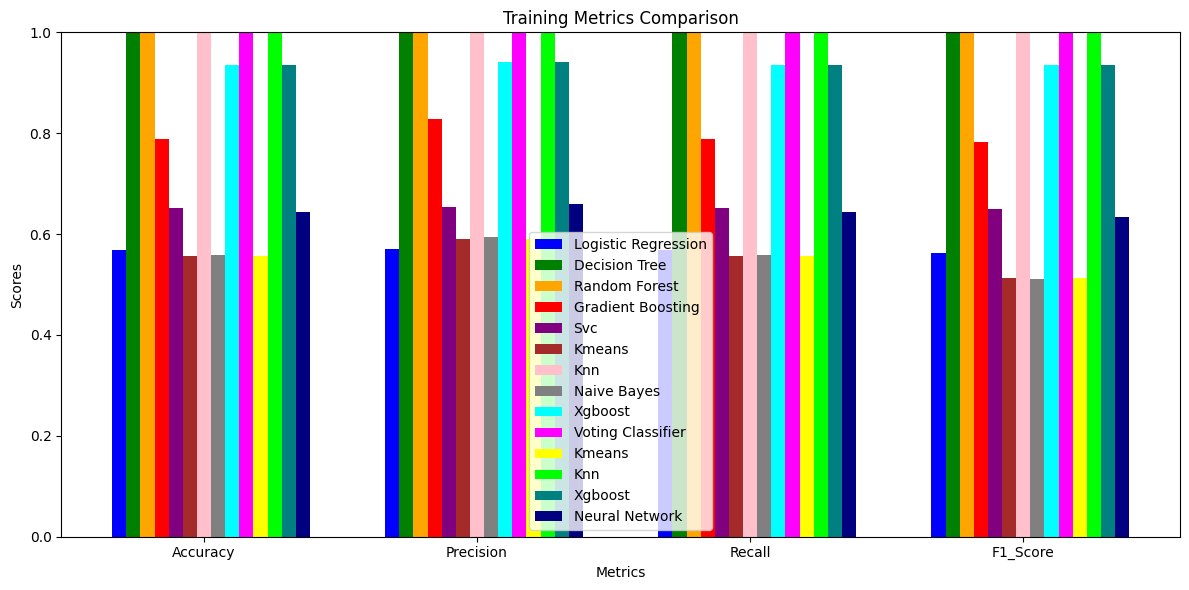

{'accuracy_Logistic_Regression': 0.5563031161473088, 'precision_Logistic_Regression': 0.5587294486953109, 'recall_Logistic_Regression': 0.5563031161473088, 'f1_score_Logistic_Regression': 0.5516725968998583, 'accuracy_Decision_Tree': 0.6554532577903682, 'precision_Decision_Tree': 0.6558698762582257, 'recall_Decision_Tree': 0.6554532577903682, 'f1_score_Decision_Tree': 0.6552228724810522, 'accuracy_Random_Forest': 0.7308781869688386, 'precision_Random_Forest': 0.7547213245384922, 'recall_Random_Forest': 0.7308781869688386, 'f1_score_Random_Forest': 0.7244295070382026, 'accuracy_XGBoost': 0.7609773371104815, 'precision_XGBoost': 0.7757673645799932, 'recall_XGBoost': 0.7609773371104815, 'f1_score_XGBoost': 0.7577289510344816, 'accuracy_SVC': 0.5704674220963173, 'precision_SVC': 0.5732457162459681, 'recall_SVC': 0.5704674220963173, 'f1_score_SVC': 0.5663552613372921, 'accuracy_KNN': 0.5237252124645893, 'precision_KNN': 0.524103973930081, 'recall_KNN': 0.5237252124645893, 'f1_score_KNN': 0.

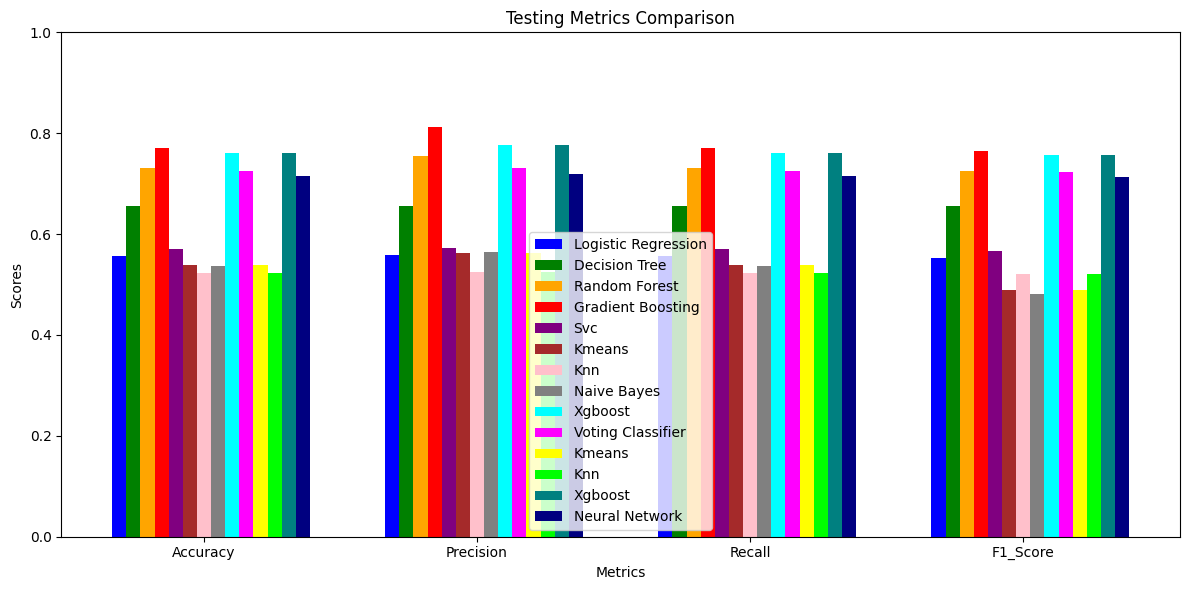

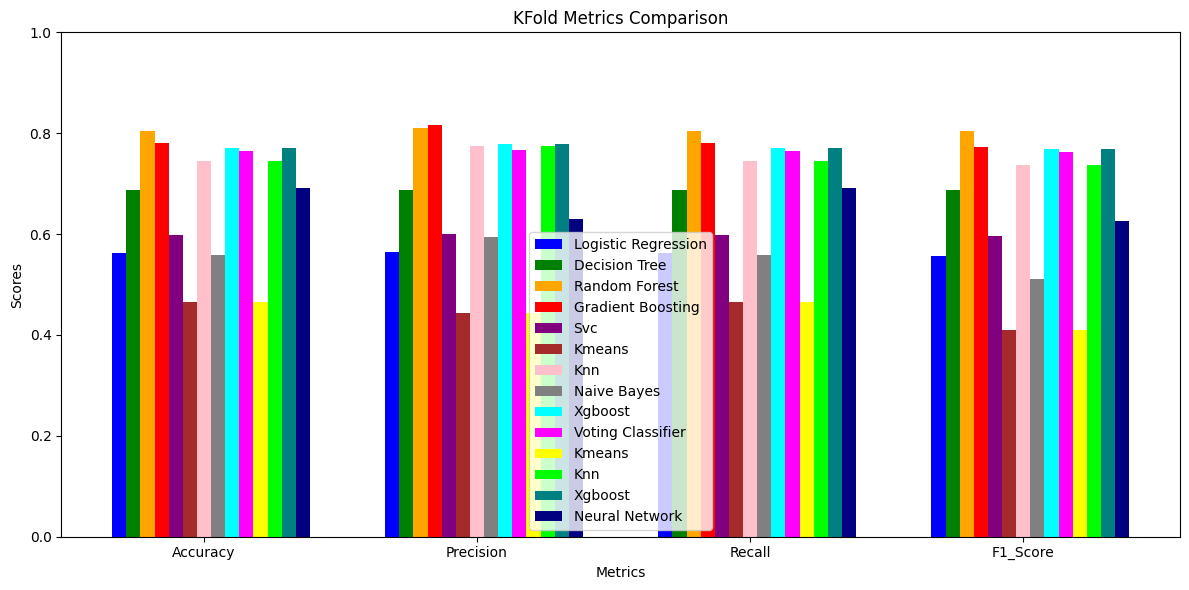

In [125]:
if "Neural_Network" in models_name:
    models_name.remove("Neural_Network")
graph_models(metrics_train, metrics_test, models_name)